In [268]:
import collections
# Prepare paths to local utilities
import os
import sys

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [269]:
models_path = os.path.abspath(os.path.join('..', 'model'))
utils_path = os.path.abspath(os.path.join('..', 'util'))
sys.path.append(models_path)
sys.path.append(utils_path)

In [270]:

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [271]:
from download.DataDownloader import DataDownloader
from collect.DataframeCollector import DataframeCollector
from collect.TestSetSplitter import TestSetSplitter
from reservoir.BasicESN import BasicESN

In [272]:
data_path = os.path.abspath(os.path.join('..', 'data'))

In [273]:
# Download data
downloader = DataDownloader()
downloader.download_data('har70plus', data_path)

Dataset already downloaded


True

In [274]:
# Collect data into dataframes
collector = DataframeCollector()
collector.load_full_dataset(data_path + '/har70plus')

Discovered  18  csv files in  E:\PyCharm\COM6906-Dissertation\data/har70plus
Loading the csv files into dataframes
Loaded  18  dataframes
Concatenating the dataframes


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,record_num
0,2021-03-24 14:42:03.839,-0.999023,-0.063477,0.140625,-0.980469,-0.112061,-0.048096,6,0
1,2021-03-24 14:42:03.859,-0.980225,-0.079346,0.140625,-0.961182,-0.121582,-0.051758,6,1
2,2021-03-24 14:42:03.880,-0.950195,-0.076416,0.140625,-0.949463,-0.080566,-0.067139,6,2
3,2021-03-24 14:42:03.900,-0.954834,-0.059082,0.140381,-0.957520,-0.046143,-0.050781,6,3
4,2021-03-24 14:42:03.920,-0.972412,-0.042969,0.142822,-0.977051,-0.023682,-0.026611,6,4
...,...,...,...,...,...,...,...,...,...
2259592,2021-06-11 11:13:14.098,-0.960693,-0.199951,-0.330566,-0.977051,0.006104,-0.246826,1,2259592
2259593,2021-06-11 11:13:14.118,-0.942627,-0.210205,-0.331543,-0.969482,0.004883,-0.231445,1,2259593
2259594,2021-06-11 11:13:14.138,-0.907227,-0.190918,-0.320312,-1.048096,0.067627,-0.234375,1,2259594
2259595,2021-06-11 11:13:14.159,-0.883057,-0.156982,-0.311279,-1.007080,0.063965,-0.248047,1,2259595


In [275]:
# The collector provides one large dataframe with all the data concatenated, and also an array of dataframes, one for each subject
dataframes = collector.get_dataframes()

test_split = 0.2
train_split = 1 - test_split
validation_split = 0.2

validation_from_train = True
use_slices = False

splitter = TestSetSplitter(test_split=test_split, val_split=validation_split, val_from_train=validation_from_train, seed=1234)
train, val, test = splitter.split(dataframes, use_slices=use_slices)

Data shape:  [(103860, 9), (131367, 9), (116413, 9), (150758, 9), (87006, 9), (122714, 9), (120125, 9), (130494, 9), (121763, 9), (122061, 9), (128063, 9), (119310, 9), (123599, 9), (101510, 9), (153517, 9), (138278, 9), (147045, 9), (141714, 9)]


In [276]:
slice_size = 128
slices_in_df_1 = len(collector.get_dataframes()[0]) // slice_size

print(len(train), len(val), len(test))

17 17 18


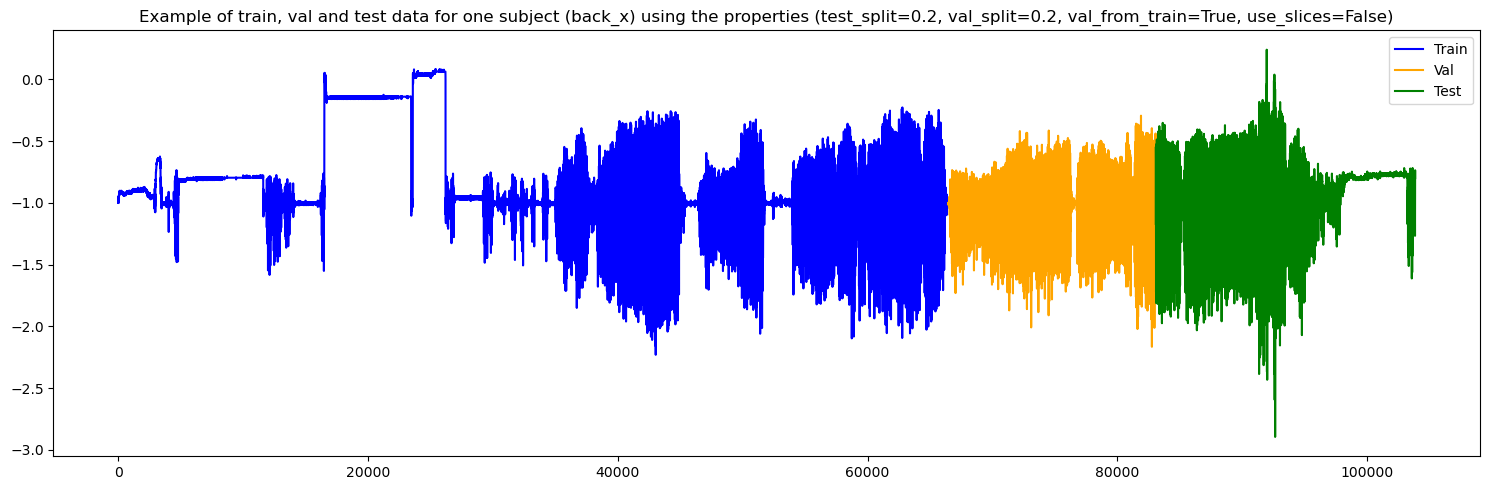

In [277]:
# Lets plot the data on a graph, colouring by whether it is train, val or test data
# Plot the column for back_x
plt.figure(figsize=(15, 5))
if (use_slices):
    train_slice = int(((slices_in_df_1 * train_split) * (1 - validation_split)) if validation_from_train else (slices_in_df_1 * (1 - test_split - validation_split)))
    for i, df in enumerate(train[:train_slice]):
        plt.plot(df['back_x'], label='Train', color='blue')
    
    val_slice = int((slices_in_df_1 * train_split) * validation_split) if validation_from_train else (slices_in_df_1 * validation_split)
    for i, df in enumerate(val[:val_slice]):
        plt.plot(df['back_x'], label='Val', color='orange')
    
    test_slice = int((slices_in_df_1 * test_split))
    for i, df in enumerate(test[:test_slice]):
        plt.plot(df['back_x'], label='Test', color='green')
        
    # Define a custom legend
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='blue', lw=2),
                    Line2D([0], [0], color='orange', lw=2),
                    Line2D([0], [0], color='green', lw=2)]
    plt.legend(custom_lines, ['Train', 'Val', 'Test'])
else:
    plt.plot(train[0]['back_x'], label='Train', color='blue')
    plt.plot(val[0]['back_x'], label='Val', color='orange')
    plt.plot(test[0]['back_x'], label='Test', color='green')
    plt.legend()
    
plt.title(f'Example of train, val and test data for one subject (back_x) using the properties (test_split={test_split}, val_split={validation_split}, val_from_train={validation_from_train}, use_slices={use_slices})')
plt.tight_layout()
plt.show()

In [278]:
# To use this ESN, we need to concatenate all of the training data into one large dataframe
train_df = pd.concat(train)

In [279]:
# Check the shape of the dataframe
train_df.shape

(1357646, 9)

In [280]:
# Let's split the data into input and output, where the input is the 6 columns ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z'] and the output is the label column 'label'
input_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
output_columns = ['label']

X_train = train_df[input_columns].values
y_train = train_df[output_columns].values

X_train.shape, y_train.shape

((1357646, 6), (1357646, 1))

In [281]:
# The label can be one of 7 values, so we need to one-hot encode it
from sklearn.preprocessing import OneHotEncoder

# The 7 values it can be are [1,3,4,5,6,7,8]

# Create the encoder
encoder = OneHotEncoder(categories='auto')

# Fit the encoder to the labels
encoder.fit(y_train)

# Transform the labels
y_train = encoder.transform(y_train).toarray()

# Check the shape of the one-hot encoded labels
y_train.shape


(1357646, 7)

In [282]:
# Get the first few rows of the one-hot encoded labels
y_train[:5]

array([[0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.]])

In [283]:
# The x data should be normalised to between -1 and 1
from sklearn.preprocessing import MinMaxScaler

# Create the scaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scaler to the data
scaler.fit(X_train)

# Transform the data
X_train = scaler.transform(X_train)

# Check the shape of the normalised data
X_train.shape

(1357646, 6)

In [284]:
# Get the first few rows of the normalised data
X_train[:5]

array([[ 0.419942  , -0.07997786,  0.36006019,  0.25384288, -0.19988966,
         0.09211758],
       [ 0.42794747, -0.09042709,  0.36006019,  0.25744639, -0.2018468 ,
         0.09128671],
       [ 0.44073629, -0.08849778,  0.36006019,  0.25963591, -0.19341553,
         0.08779696],
       [ 0.43876069, -0.0770839 ,  0.35990984,  0.25813058, -0.18633951,
         0.09150838],
       [ 0.43127478, -0.066474  ,  0.36141392,  0.25448149, -0.18172242,
         0.09699225]])

In [285]:
# Now we need to create the ESN

# We can star by defining the input weights for the data

# To do this, we will create a matrix of shape (n_neurons, n_features) where n_neurons is the number of neurons in the reservoir and n_features is the number of features in the input signal
# We will then populate this matrix from a density function where elements are 1 for a value p, and 0 for a value of 1-p
# This will give us a sparse matrix with a density of p

n_features = 6
density = 0.1
n_neurons = 100

# Generate the input weights
input_weights = np.random.rand(n_neurons, n_features) < density

# Check the shape of the input weights
print(input_weights.shape)



(100, 6)


In [286]:
# Next, we initialise the ESN
# We will use the BasicESN class from the reservoir.BasicESN module

leakage_rate = 0.3
spectral_radius = 0.9
gamma = 1.0
W_in = input_weights

esn = BasicESN(leakage_rate=leakage_rate, spectral_radius=spectral_radius, gamma=gamma, n_neurons=n_neurons, W_in=W_in)

BasicESN initialised with leakage_rate: 0.3, spectral_radius: 0.9, gamma: 1.0, n_neurons: 100


In [287]:
# Now we need to train the ESN
# We will train the ESN using the training data

# As a test, lets only take the first 1000 samples
n_samples = 500000
data_in = X_train
data_out = y_train

esn.fit(data_in, data_out)


100%|██████████| 1357646/1357646 [03:15<00:00, 6940.28it/s] 


Shape of previous_states: (1357646, 100)
Shape of state before fitting: (1357646, 100)
Shape of y before fitting: (1357646, 7)


In [288]:
# Now we can use the ESN to predict the output for the test data

# First we need to concatenate the test data into one large dataframe
test_df = pd.concat(test)

# Check the shape of the dataframe
test_df.shape

(562547, 9)

In [289]:
# Split the data into input and output
X_test = test_df[input_columns].values
y_test = test_df[output_columns].values

# One-hot encode the labels
y_test = encoder.transform(y_test).toarray()

# Normalise the input data
X_test = scaler.transform(X_test)

# Check the shape of the data
X_test.shape, y_test.shape

((562547, 6), (562547, 7))

In [290]:
# Get the first few rows of the data
X_test[:5], y_test[:5]

(array([[ 0.34695373, -0.09830435,  0.14960493,  0.2295761 , -0.18277633,
          0.14058597],
        [ 0.36265336, -0.05666743,  0.17954101,  0.24075168, -0.17770741,
          0.14728845],
        [ 0.42763574, -0.04718286,  0.20767232,  0.26729917, -0.16626509,
          0.1066858 ],
        [ 0.50966944, -0.03769829,  0.20631798,  0.25370612, -0.19988966,
          0.10552254],
        [ 0.56664592, -0.03496498,  0.20285817,  0.25407101, -0.22874625,
          0.09887542]]),
 array([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]]))

In [291]:
# Now we can use the ESN to predict the output for the test data
y_pred = esn.forward(X_test)

# Check the shape of the predicted output
y_pred.shape


100%|██████████| 562547/562547 [01:12<00:00, 7748.71it/s] 


Shape of previous_states: (562547, 100)


(562547, 7)

In [292]:
# Get the first few rows of the predicted output
y_pred[:5]

array([[ 2.847094  , -0.27608233, -0.02580748,  0.03483189, -1.79776244,
         0.06614935,  0.151577  ],
       [ 2.48745115, -0.24259055, -0.02232707,  0.02583461, -1.55076549,
         0.04817075,  0.2542266 ],
       [ 2.24923573, -0.20098395, -0.02064833,  0.02453343, -1.37179131,
         0.04391944,  0.27573499],
       [ 1.95099593, -0.19086906, -0.01032233,  0.02044786, -1.09825138,
         0.00810275,  0.31989623],
       [ 1.80283892, -0.18206322, -0.00683612,  0.01753104, -0.93865407,
        -0.02108345,  0.3282669 ]])

In [293]:
# The predicted output is a one-hot encoded array, so we need to decode it back to the original labels
y_pred_decoded = encoder.inverse_transform(y_pred)

# Check the shape of the decoded output
y_pred_decoded.shape

(562547, 1)

In [294]:
# Get the first few rows of the decoded output
y_pred_decoded[:5]

array([[1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

In [295]:
y_test_decoded = encoder.inverse_transform(y_test)

# Check the shape of the decoded output
y_test_decoded.shape

(562547, 1)

In [296]:
y_test_decoded[:5]

array([[1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

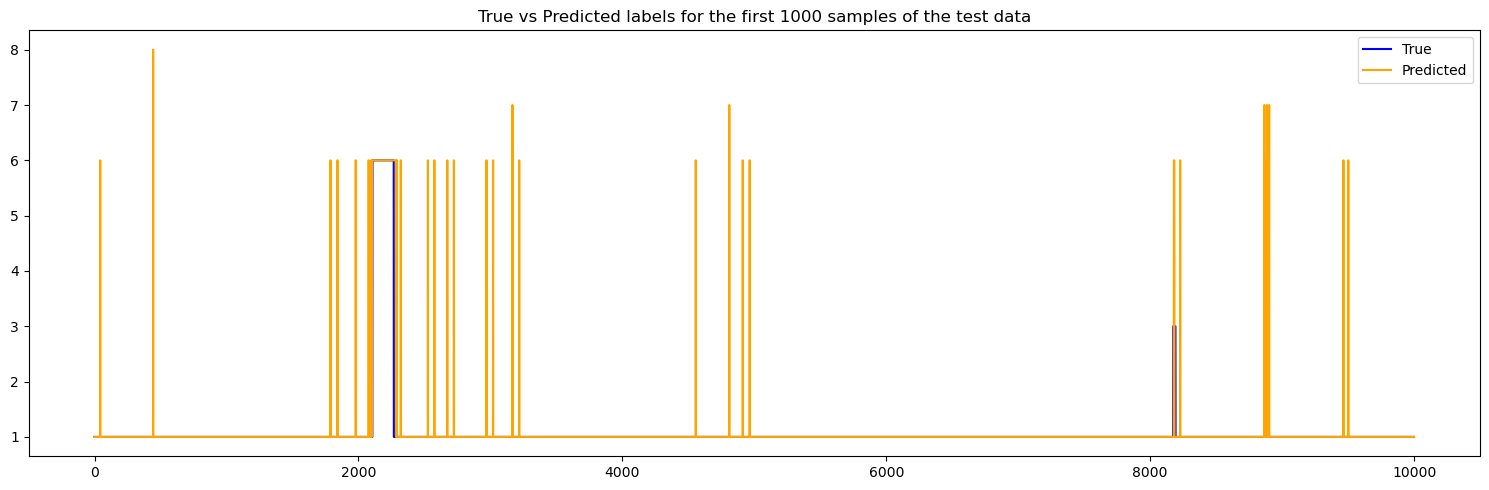

In [297]:
# Now we can evaluate the accuracy of the ESN on the test data
# Start by plotting the true label and the predicted label on a graph
plt.figure(figsize=(15, 5))
plt.plot(y_test_decoded[:10000], label='True', color='blue')
plt.plot(y_pred_decoded[:10000], label='Predicted', color='orange')
plt.legend()
plt.title('True vs Predicted labels for the first 1000 samples of the test data')

plt.tight_layout()
plt.show()

In [298]:
# Now we can calculate the accuracy of the ESN on the test data
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_decoded, y_pred_decoded)

accuracy

0.7902308607103051

In [299]:
# Now we can calculate the confusion matrix for the ESN on the test data
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

conf_matrix

array([[321042,      0,      0,      0,  24134,   1402,      3],
       [ 15741,      0,      0,      0,   3887,     12,      0],
       [  2507,      0,      0,      0,    105,     96,      0],
       [   360,      0,      0,      0,     10,      0,      0],
       [ 67913,      0,      0,      0,  73877,      6,      0],
       [  1818,      0,      0,      0,      7,  41378,      1],
       [     3,      0,      0,      0,      0,      0,   8245]],
      dtype=int64)

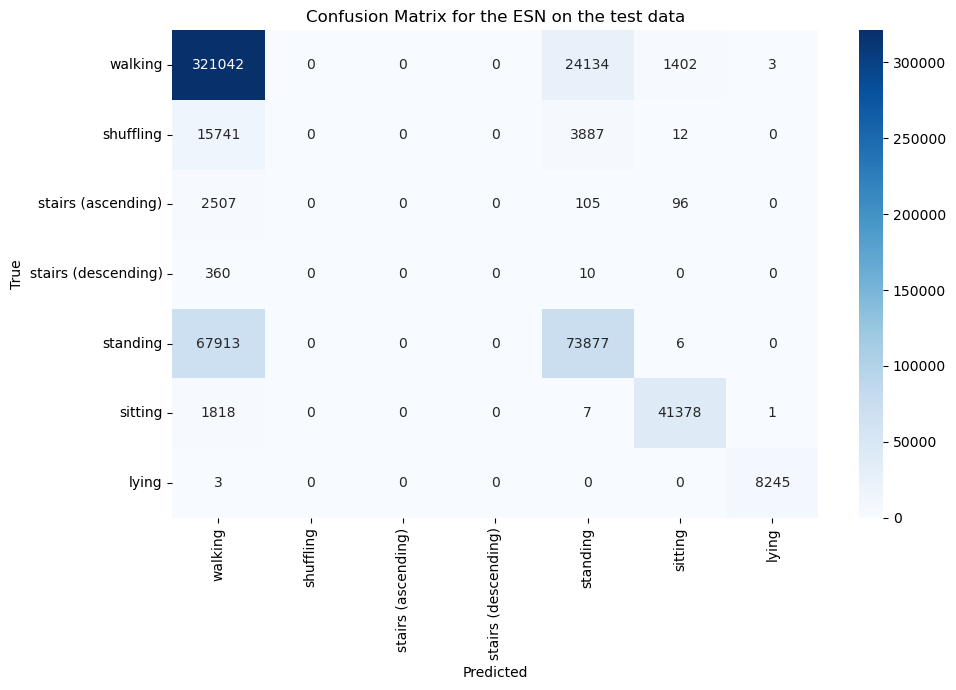

In [300]:
# Now we can plot the confusion matrix
# Our labels are 
# 1: walking	
# 3: shuffling
# 4: stairs (ascending)
# 5: stairs (descending)
# 6: standing
# 7: sitting
# 8: lying
# So we will use these labels for the x and y axis of the confusion matrix
import seaborn as sns

labels = ['walking', 'shuffling', 'stairs (ascending)', 'stairs (descending)', 'standing', 'sitting', 'lying']

plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confusion Matrix for the ESN on the test data')

plt.tight_layout()
plt.show()


In [301]:
# Now we can calculate the precision, recall and f1-score for the ESN on the test data
from sklearn.metrics import classification_report

report = classification_report(y_test_decoded, y_pred_decoded, target_names=labels)

print(report)

C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

            walking       0.78      0.93      0.85    346581
          shuffling       0.00      0.00      0.00     19640
 stairs (ascending)       0.00      0.00      0.00      2708
stairs (descending)       0.00      0.00      0.00       370
           standing       0.72      0.52      0.61    141796
            sitting       0.96      0.96      0.96     43204
              lying       1.00      1.00      1.00      8248

           accuracy                           0.79    562547
          macro avg       0.50      0.49      0.49    562547
       weighted avg       0.75      0.79      0.76    562547



C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [302]:
# Now that we have done a test with basic properties, we can tune the hyperparameters of the ESN to see if we can improve the accuracy

# First, lets define the search space for the hyperparameters
from hyperopt import hp

space = {
    'leakage_rate': hp.uniform('leakage_rate', 0.1, 0.9),
    'spectral_radius': hp.uniform('spectral_radius', 0.1, 1.0),
    'gamma': hp.uniform('gamma', 0.1, 1.0),
    'n_neurons': hp.choice('n_neurons', [100, 200, 300]),
    'density': hp.uniform('density', 0.1, 0.9)
}

# Next, we define the objective function
from hyperopt import fmin, tpe, Trials
from sklearn.metrics import mean_squared_error

def objective(params):
    # Create the input weights
    input_weights = np.random.rand(params['n_neurons'], n_features) < params['density']
    
    # Create the ESN
    esn = BasicESN(leakage_rate=params['leakage_rate'], spectral_radius=params['spectral_radius'], gamma=params['gamma'], n_neurons=params['n_neurons'], W_in=input_weights, is_optimising=True)
    
    # Train the ESN
    esn.fit(data_in, data_out)
    
    # Predict the output
    y_pred = esn.forward(X_test)
    
    # Decode the output
    y_pred_decoded = encoder.inverse_transform(y_pred)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_test_decoded, y_pred_decoded)
    
    return mse

# Now we can run the hyperparameter search
trials = Trials()

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

best

BasicESN initialised with leakage_rate: 0.5625103781971709, spectral_radius: 0.6651094578815644, gamma: 0.23173932391980892, n_neurons: 300
Shape of previous_states: (1357646, 300)               
Shape of state before fitting: (1357646, 300)          
Shape of y before fitting: (1357646, 7)                
Shape of previous_states: (562547, 300)                
BasicESN initialised with leakage_rate: 0.713372473029893, spectral_radius: 0.5003219165119968, gamma: 0.5452579356527695, n_neurons: 100
Shape of previous_states: (1357646, 100)                                              
Shape of state before fitting: (1357646, 100)                                         
Shape of y before fitting: (1357646, 7)                                               
Shape of previous_states: (562547, 100)                                               
BasicESN initialised with leakage_rate: 0.6101048889080144, spectral_radius: 0.6992342700934937, gamma: 0.16040378067482491, n_neurons: 50
Shape of pr

KeyboardInterrupt: 